# Homework 3 

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [2]:
def des_or_for(image):
    """
    :param image: исходное изображение (RGB)
    :return: 1 - Пустыня, 0 - Лес
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray.ravel()], [0], None, [256], [0, 256])
    if np.argmax(hist) > len(hist)//2:
        return 1
    return 0

In [3]:
image = cv2.imread('desert_forest/test_image_00.jpg')
h, w, _ = image.shape
image = cv2.resize(image.copy(), (w // 2, h // 2))
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# grayscale
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

It's forest


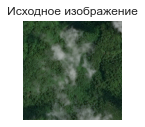

In [4]:
plt.subplot(211)
plt.imshow(image)
plt.title('Исходное изображение'), plt.axis('off')
if des_or_for(image):
    print("It's desert")
else:
    print("It's forest")

In [5]:
for i in range(10):
    imagei = cv2.imread(f'desert_forest/test_image_0{i}.jpg')
    h, w, _ = imagei.shape
    imagei = cv2.resize(imagei.copy(), (w // 2, h // 2))
    imagei = cv2.cvtColor(imagei.copy(), cv2.COLOR_BGR2RGB)
    if des_or_for(imagei):
        print(f"{i}: It's desert")
    else:
        print(f"{i}: It's forest")

for i in range(10, 17):
    imagei = cv2.imread(f'desert_forest/test_image_{i}.jpg')
    h, w, _ = imagei.shape
    imagei = cv2.resize(imagei.copy(), (w // 2, h // 2))
    imagei = cv2.cvtColor(imagei.copy(), cv2.COLOR_BGR2RGB)
    if des_or_for(imagei):
        print(f"{i}: It's desert")
    else:
        print(f"{i}: It's forest")


0: It's forest
1: It's forest
2: It's forest
3: It's forest
4: It's forest
5: It's forest
6: It's desert
7: It's forest
8: It's forest
9: It's forest
10: It's desert
11: It's desert
12: It's desert
13: It's desert
14: It's desert
15: It's desert
16: It's desert


# Задача №2 - Раздели объекты в шуме

Дано зашумленное изображение с 3 объектами: круг, треугольник и фон. Треубется выдлеить каждый объект, фон, круг и треугольник в бинарные маски. То есть треубется найти геометрическое место каждого объекта на изображении. Незашумленное изображение приведено __только__ для оценки качества решения. Запрещено использовать любую инофрмацию о незашумленном изоьражении в решении. 

Придумайте способ численной оценки качества полученного результата.

<table><tr>
    <td> <img src="segmentation/gt.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="segmentation/noise.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [6]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    plt.figure(figsize=(6.4 * 2, 4.8 * 2), constrained_layout=True
)
    cmap = 'gray' if is_gray else None
    
    plt.subplot(121)
    plt.imshow(src_image, cmap=cmap)
    plt.axis('off'), plt.title('Исходное изображение')
    
    plt.subplot(122)
    plt.imshow(transform_image, cmap=cmap)
    plt.axis('off'), plt.title('Результат преобразования')
    
    plt.show()

In [393]:
def cleaning(image):
    blur = cv2.GaussianBlur(image.copy(), (7,7), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    return closing
    

In [647]:
def plot_hist(image, zero = False):
    hist = cv2.calcHist([image.ravel()], [0], None, [256], [0, 256])
    if zero:
        hist[0] = 0
    plt.plot(hist)
    plt.title('Гистограмма по освещенности1')
    plt.show()

In [648]:
def circ_or_triangle(image, mask, size = 100):
    h_size = size //2;
    hist = cv2.calcHist([image.ravel()], [0], None, [256], [0, 256])
    hist[0] = 0

    sorted_index_hist = np.argsort(hist.T)
    col = sorted_index_hist[0][-2:]
    
    im = np.pad(image.copy(), h_size)
    pad_mask = np.pad(mask.copy(), h_size)
    
#     im = image.copy()
    res1 = np.zeros(im.shape)
    res2 = np.zeros(im.shape)
    H, W = im.shape
    for y in range(h_size, H-h_size):
        for x in range(h_size, W-h_size):
            im_slice = im[y-h_size:y+h_size, x-h_size:x+h_size]
            if not pad_mask[y][x]:
                continue
                
            if np.sum(im_slice == col[0]) > np.sum(im_slice == col[1]):
                res1[y][x] = 1
            else:
                res2[y][x] = 1

    return res1, res2

In [649]:
def figures(image, metod=2):
    hist = cv2.calcHist([image.ravel()], [0], None, [256], [0, 256])
#     plot_hist(image)
    
    clean_mask = np.ceil(cleaning(image)/255)
    clean_image = np.uint8(clean_mask*image)
#     plot_hist(clean_image, True)
#     clean_image = smoothing(clean_image)
#     plot_hist(clean_image, True)
    plot_transform_result(clean_mask, clean_image, is_gray=True)
    
    fig1, fig2 = circ_or_triangle(clean_image, clean_mask)
    fig1 *= 255
    fig2 *= 255
    plot_transform_result(fig1, fig2, is_gray=True)
    

    plt.show()
    

(390, 530)


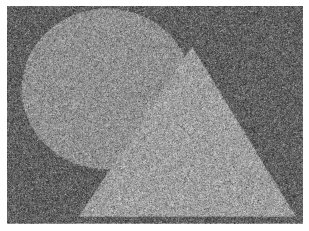

In [650]:
image = cv2.imread('segmentation/noise.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

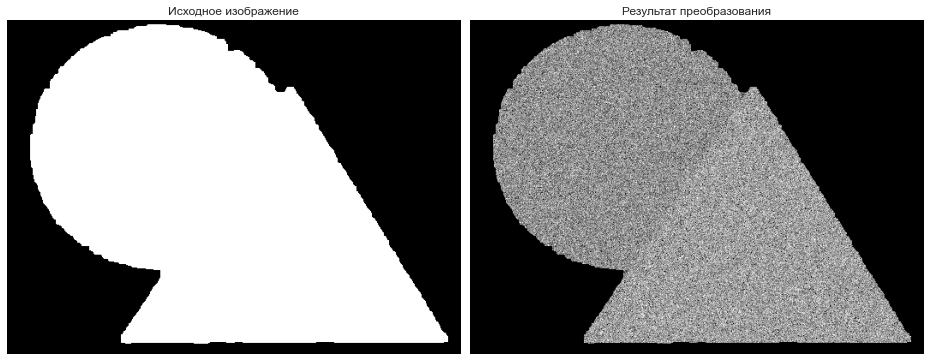

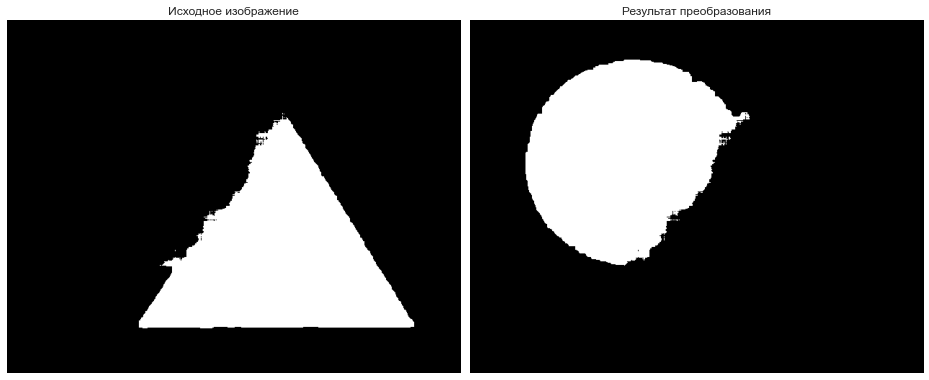

In [651]:
figures(image)

(394, 532)


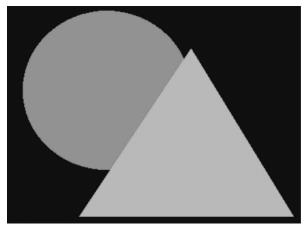

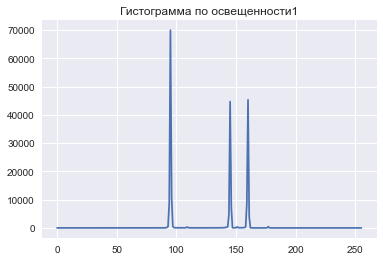

In [652]:
image_clean = cv2.imread('segmentation/gt.png')
image_clean = cv2.cvtColor(image_clean, cv2.COLOR_BGR2GRAY)
print(image_clean.shape)

plt.imshow(image_clean, cmap='gray')
plt.axis('off')
plt.show()
plot_hist(image_clean, False)

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="./cells/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

In [130]:
def cells(image, cell_size, cell_count):
    im_inf = (image != 255).astype(float)
    
    y_size = np.int32(np.ceil(image.shape[0] / cell_size))
    x_size = np.int32(np.ceil(image.shape[1] / cell_size))
    map_inf = np.zeros((y_size,x_size))
    
    for i in range(y_size):
        for j in range(x_size):
            map_inf[i][j] = np.sum(im_inf[i*cell_size : (i+1)*cell_size+1, j*cell_size : (j+1)*cell_size+1])/cell_size**2
            
#     plt.imshow((map_inf*255).astype(int), cmap='gray')
    plt.show()
    
    map_inf = np.pad(map_inf, 1)
#     print(map_inf)
    map_corner = np.zeros((y_size+1, x_size+1))
    for i in range(y_size+1):
        for j in range(x_size+1):
            map_corner[i][j] = np.sum(map_inf[i : i+2, j : j+2])
    
    corners = [[map_corner[i//(x_size+1)][i%(x_size+1)], i//(x_size+1), i%(x_size+1)] for i in range((x_size+1)*(y_size+1))]
    sort_corn = sorted(corners, key=lambda x: x[0], reverse=True)
#     print(sort_corn)
    
#     cells_corn = sort_corn[:cell_count]
    
    cells = np.zeros((cell_count, 2))
    for i in range(cell_count):
        _, y, x = sort_corn[i]
#         print(y,x)
        s = np.sum(map_inf[y:y+2, x:x+2])
        w1 = map_inf[y][x]/s
        w2 = map_inf[y][x+1]/s
        w3 = map_inf[y+1][x]/s
        w4 = map_inf[y+1][x+1]/s
#         print(w1,w2,w3,w4)
            
        cells[i][0] = np.round(y*cell_size - (w1+w2)*cell_size)
#         if cells[i][0] < 0:
#             cells[i][0] = 0
        
        cells[i][1] = np.round(x*cell_size - (w1+w3)*cell_size)
#         if cells[i][1] < 0:
#             cells[i][1] = 0
        
#         map_inf[y][x] *= 1-w1
#         map_inf[y][x+1] *= 1-w2
#         map_inf[y+1][x] *= 1-w3
#         map_inf[y+1][x+1] *= 1-w4
        map_inf[y][x] -= (w1+w2)*(w1+w3)
        if map_inf[y][x] < 0: map_inf[y][x] = 0
            
        map_inf[y][x+1] -= (w1+w2)*(w2+w4)
        if map_inf[y][x+1] < 0: map_inf[y][x+1] = 0
            
        map_inf[y+1][x] -= (w3+w4)*(w1+w3)
        if map_inf[y+1][x] < 0: map_inf[y+1][x] = 0
            
        map_inf[y+1][x+1] -= (w3+w4)*(w2+w4)
        if map_inf[y+1][x+1] < 0: map_inf[y+1][x+1] = 0
        
    cells = cells.astype(int)
#     print(cells)
        
#     count_side = np.int32(np.ceil(np.sqrt(cell_count)))
#     res = np.zeros((count_side*cell_size, count_side*cell_size))
    
#     im = np.pad(image, cell_size)
#     for i in range(cell_count):
#         y_res = (i//count_side)*cell_size
#         x_res = (i%count_side)*cell_size
#         y,x = cells[i]
# #         print(y,x)
        
#         res[y_res:y_res+cell_size, x_res:x_res+cell_size] = im[y:y+cell_size, \
#                                                                    x:x+cell_size]
#     print(res)
#     plt.imshow((map_corner/np.max(map_corner)*255).astype(int), cmap='gray')
#     plt.imshow(res, cmar='gray')
    
    im_res =  image.copy()
    for i in range(cell_count):
        y,x = cells[i]
        y1 = y+cell_size
        x1 = x+cell_size
        im_res = cv2.rectangle(im_res,(x,y),(x1,y1),0,3)

    plt.figure(figsize=(20,20))
    plt.imshow(im_res, cmap='gray')
    plt.axis('off')
    plt.show()
    

In [131]:
# def cells(image, cell_size, cell_count):
#     im_inf = (image != 255).astype(float)
    
#     y_size = np.int32(np.ceil(image.shape[0] / cell_size))
#     x_size = np.int32(np.ceil(image.shape[1] / cell_size))
#     map_inf = np.zeros((y_size,x_size))
    
#     for i in range(y_size):
#         for j in range(x_size):
#             map_inf[i][j] = np.sum(im_inf[i*cell_size : (i+1)*cell_size+1, j*cell_size : (j+1)*cell_size+1])/cell_size**2
            
# #     plt.imshow((map_inf*255).astype(int), cmap='gray')
#     plt.show()
    
#     map_inf = np.pad(map_inf, 1)

#     cells = np.zeros((cell_count, 2))
#     for k in range(cell_count):
#         map_corner = np.zeros((y_size+1, x_size+1))
#         for i in range(y_size+1):
#             for j in range(x_size+1):
#                 map_corner[i][j] = np.sum(map_inf[i : i+2, j : j+2])

#         corners = [[map_corner[i//(x_size+1)][i%(x_size+1)], i//(x_size+1), i%(x_size+1)] for i in range((x_size+1)*(y_size+1))]
#         sort_corn = sorted(corners, key=lambda x: x[0], reverse=True)
    
    
#         _, y, x = sort_corn[0]
#         s = np.sum(map_inf[y:y+2, x:x+2])
#         w1 = map_inf[y][x]/s
#         w2 = map_inf[y][x+1]/s
#         w3 = map_inf[y+1][x]/s
#         w4 = map_inf[y+1][x+1]/s
            
#         cells[k][0] = np.round(y*cell_size - (w1+w2)*cell_size)

#         cells[k][1] = np.round(x*cell_size - (w1+w3)*cell_size)

#         map_inf[y][x] *= 1-(w1+w2)*(w1+w3)
#         map_inf[y][x+1] *= 1-(w1+w2)*(w2+w4)
#         map_inf[y+1][x] *= 1-(w3+w4)*(w1+w3)
#         map_inf[y+1][x+1] *= 1-(w3+w4)*(w2+w4)
        
#     cells = cells.astype(int)
    
#     im_res =  image.copy()
#     for i in range(cell_count):
#         y,x = cells[i]
#         y1 = y+cell_size
#         x1 = x+cell_size
#         im_res = cv2.rectangle(im_res,(x,y),(x1,y1),0,3)

#     plt.figure(figsize=(20,20))
#     plt.imshow(im_res, cmap='gray')
#     plt.axis('off')
#     plt.show()
    

(7688, 3880)


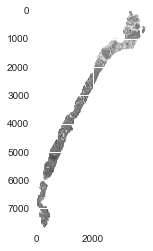

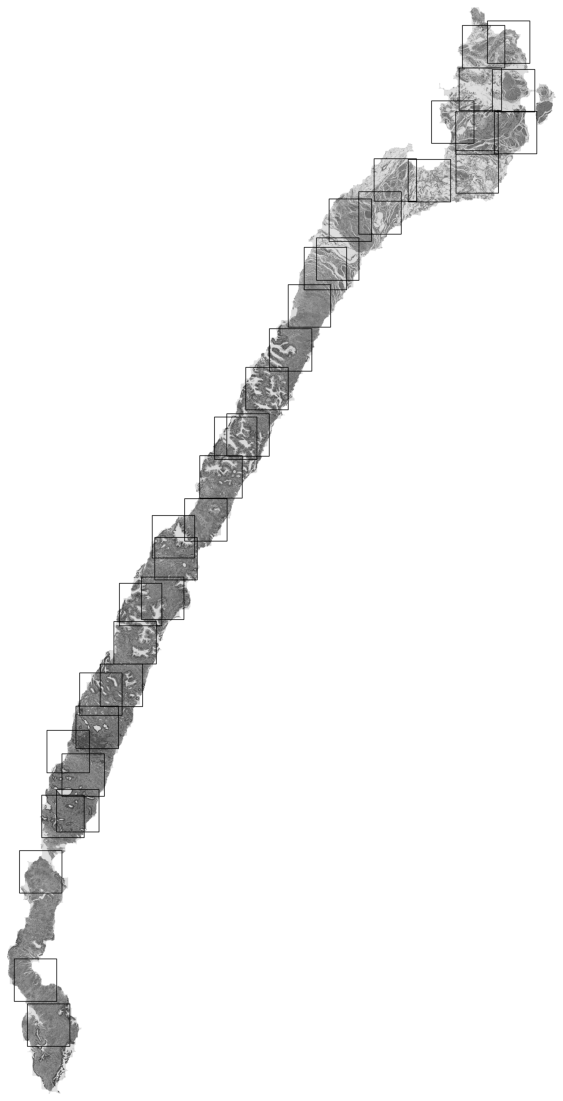

In [134]:
image = cv2.imread('cells/train2_1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()
cells(image, 300, 36)